In [ ]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
import numpy as np
import pandas as pd
import shutil
import time
import cv2 as cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from IPython.core.display import display, HTML
# stop annoying tensorflow warning messages
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
def preprocess (sdir, trsplit, vsplit):
    filepaths=[]
    labels=[]    
    classlist=os.listdir(sdir)
    for klass in classlist:
        classpath=os.path.join(sdir,klass)
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)
    Fseries=pd.Series(filepaths, name='filepaths')
    Lseries=pd.Series(labels, name='labels')
    df=pd.concat([Fseries, Lseries], axis=1)       
    # split df into train_df and test_df 
    dsplit=vsplit/(1-trsplit)
    strat=df['labels']    
    train_df, dummy_df=train_test_split(df, train_size=trsplit, shuffle=True, random_state=123, stratify=strat)
    strat=dummy_df['labels']
    valid_df, test_df=train_test_split(dummy_df, train_size=dsplit, shuffle=True, random_state=123, stratify=strat)
    print('train_df length: ', len(train_df), '  test_df length: ',len(test_df), '  valid_df length: ', len(valid_df))
    print(train_df['labels'].value_counts())
    return train_df, test_df, valid_df
    

In [ ]:
sdir=r'/content/gdrive/MyDrive/SM/IMG_CLASSES'
train_df, test_df, valid_df= preprocess(sdir, .8,.1)

train_df length:  21722   test_df length:  2716   valid_df length:  2715
5. Melanocytic Nevi (NV) - 7970                                     6376
4. Basal Cell Carcinoma (BCC) 3323                                  2658
2. Melanoma 15.75k                                                  2512
10. Warts Molluscum and other Viral Infections - 2103               1682
6. Benign Keratosis-like Lesions (BKL) 2624                         1663
7. Psoriasis pictures Lichen Planus and related diseases - 2k       1644
8. Seborrheic Keratoses and other Benign Tumors - 1.8k              1477
9. Tinea Ringworm Candidiasis and other Fungal Infections - 1.7k    1362
1. Eczema 1677                                                      1342
3. Atopic Dermatitis - 1.25k                                        1006
Name: labels, dtype: int64


In [ ]:
def balance(train_df,max_samples, min_samples, column, working_dir, image_size):
    train_df=train_df.copy()
    train_df=trim (train_df, max_samples, min_samples, column)    
    # make directories to store augmented images
    aug_dir=os.path.join(working_dir, 'aug')
    if os.path.isdir(aug_dir):
        shutil.rmtree(aug_dir)
    os.mkdir(aug_dir)
    for label in train_df['labels'].unique():    
        dir_path=os.path.join(aug_dir,label)    
        os.mkdir(dir_path)
    # create and store the augmented images     
    gen=ImageDataGenerator(horizontal_flip=True,  rotation_range=20, width_shift_range=.2,
                                  height_shift_range=.2, zoom_range=.2)
    groups=train_df.groupby('labels') # group by class
    for label in train_df['labels'].unique():  # for every class        
        group=groups.get_group(label)  # a dataframe holding only rows with the specified label 
        sample_count=len(group)   # determine how many samples there are in this class  
        if sample_count< max_samples: # if the class has less than target number of images
            aug_img_count=0
            delta=max_samples-sample_count  # number of augmented images to create
            target_dir=os.path.join(aug_dir, label)  # define where to write the images    
            aug_gen=gen.flow_from_dataframe( group,  x_col='filepaths', y_col=None, target_size=image_size,
                                            class_mode=None, batch_size=1, shuffle=False, 
                                            save_to_dir=target_dir, save_prefix='aug-', color_mode='rgb',
                                            save_format='jpg')
            while aug_img_count<delta:
                images=next(aug_gen)            
                aug_img_count += len(images)            
    # create aug_df and merge with train_df to create composite training set ndf
    aug_fpaths=[]
    aug_labels=[]
    classlist=os.listdir(aug_dir)
    for klass in classlist:
        classpath=os.path.join(aug_dir, klass)     
        flist=os.listdir(classpath)    
        for f in flist:        
            fpath=os.path.join(classpath,f)         
            aug_fpaths.append(fpath)
            aug_labels.append(klass)
    Fseries=pd.Series(aug_fpaths, name='filepaths')
    Lseries=pd.Series(aug_labels, name='labels')
    aug_df=pd.concat([Fseries, Lseries], axis=1)    
    ndf=pd.concat([train_df,aug_df], axis=0).reset_index(drop=True)
    print (list(ndf['labels'].value_counts()) )
    return ndf 

In [ ]:
def trim (df, max_size, min_size, column):
    df=df.copy()
    sample_list=[] 
    groups=df.groupby(column)
    for label in df[column].unique():        
        group=groups.get_group(label)
        sample_count=len(group)         
        if sample_count> max_size :
            samples=group.sample(max_size, replace=False, weights=None, random_state=123, axis=0).reset_index(drop=True)
            sample_list.append(samples)
        elif sample_count>= min_size:
            sample_list.append(group)
    df=pd.concat(sample_list, axis=0).reset_index(drop=True)
    balance=list(df[column].value_counts())
    print (balance)
    return df

In [ ]:
max_samples= 1006
min_samples=0
column='labels'
working_dir = r'./'
img_size=(300, 300)
=balance(train_df,max_samples, min_samples, column, working_dir, img_size)ndf

[1006, 1006, 1006, 1006, 1006, 1006, 1006, 1006, 1006, 1006]
[1006, 1006, 1006, 1006, 1006, 1006, 1006, 1006, 1006, 1006]


<ipython-input-6-ca179941a33e>:41: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  Fseries=pd.Series(aug_fpaths, name='filepaths')
<ipython-input-6-ca179941a33e>:42: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  Lseries=pd.Series(aug_labels, name='labels')


In [ ]:
channels=3
batch_size=30
img_shape=(img_size[0], img_size[1], channels)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)
def scalar(img):    
    return img  # EfficientNet expects pixelsin range 0 to 255 so no scaling is required
trgen=ImageDataGenerator(preprocessing_function=scalar, horizontal_flip=True)
tvgen=ImageDataGenerator(preprocessing_function=scalar)
train_gen=trgen.flow_from_dataframe( ndf, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
test_gen=tvgen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)

valid_gen=tvgen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
classes=list(train_gen.class_indices.keys())
class_count=len(classes)
train_steps=int(np.ceil(len(train_gen.labels)/batch_size))

test batch size:  28   test steps:  97
Found 10060 validated image filenames belonging to 10 classes.
Found 2716 validated image filenames belonging to 10 classes.
Found 2715 validated image filenames belonging to 10 classes.


In [ ]:
def predictor(sdir, csv_path,  model_path, crop_image = False):    
    # read in the csv file
    class_df=pd.read_csv(csv_path)    
    img_height=int(class_df['height'].iloc[0])
    img_width =int(class_df['width'].iloc[0])
    img_size=(img_width, img_height)
    scale=class_df['scale by'].iloc[0] 
    try: 
        s=int(scale)
        s2=1
        s1=0
    except:
        split=scale.split('-')
        s1=float(split[1])
        s2=float(split[0].split('*')[1]) 
        print (s1,s2)
    path_list=[]
    paths=os.listdir(sdir)
    for f in paths:
        path_list.append(os.path.join(sdir,f))
    print (' Model is being loaded- this will take about 10 seconds')
    model=load_model(model_path)
    image_count=len(path_list)    
    index_list=[] 
    prob_list=[]
    cropped_image_list=[]
    good_image_count=0
    for i in range (image_count):       
        img=cv2.imread(path_list[i])
        if crop_image == True:
            status, img=crop(img)
        else:
            status=True
        if status== True:
            good_image_count +=1
            img=cv2.resize(img, img_size)            
            cropped_image_list.append(img)
            img=img*s2 - s1
            img=np.expand_dims(img, axis=0)
            p= np.squeeze (model.predict(img))           
            index=np.argmax(p)            
            prob=p[index]
            index_list.append(index)
            prob_list.append(prob)
    if good_image_count==1:
        class_name= class_df['class'].iloc[index_list[0]]
        probability= prob_list[0]
        img=cropped_image_list [0] 
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
        plt.imshow(img)
        return class_name, probability
    elif good_image_count == 0:
        return None, None
    most=0
    for i in range (len(index_list)-1):
        key= index_list[i]
        keycount=0
        for j in range (i+1, len(index_list)):
            nkey= index_list[j]            
            if nkey == key:
                keycount +=1                
        if keycount> most:
            most=keycount
            isave=i             
    best_index=index_list[isave]    
    psum=0
    bestsum=0
    for i in range (len(index_list)):
        psum += prob_list[i]
        if index_list[i]==best_index:
            bestsum += prob_list[i]  
    img= cropped_image_list[isave]/255    
    class_name=class_df['class'].iloc[best_index]
    plt.title(class_name, color='blue', fontsize=16)
    plt.axis('off')
    plt.imshow(img)
    return class_name, bestsum/image_count

In [ ]:
def saver(save_path, model, model_name, subject, accuracy,img_size, scalar, generator):
    # first save the model
    save_id=str (model_name +  '-' + subject +'-'+ str(acc)[:str(acc).rfind('.')+3] + '.h5')
    model_save_loc=os.path.join(save_path, save_id)
    model.save(model_save_loc)
    print_in_color ('model was saved as ' + model_save_loc, (0,255,0),(55,65,80)) 
    # now create the class_df and convert to csv file    
    class_dict=generator.class_indices 
    height=[]
    width=[]
    scale=[]
    for i in range(len(class_dict)):
        height.append(img_size[0])
        width.append(img_size[1])
        scale.append(scalar)
    Index_series=pd.Series(list(class_dict.values()), name='class_index')
    Class_series=pd.Series(list(class_dict.keys()), name='class') 
    Height_series=pd.Series(height, name='height')
    Width_series=pd.Series(width, name='width')
    Scale_series=pd.Series(scale, name='scale by')
    class_df=pd.concat([Index_series, Class_series, Height_series, Width_series, Scale_series], axis=1)    
    csv_name='class_dict.csv'
    csv_save_loc=os.path.join(save_path, csv_name)
    class_df.to_csv(csv_save_loc, index=False) 
    print_in_color ('class csv file was saved as ' + csv_save_loc, (0,255,0),(55,65,80)) 
    return model_save_loc, csv_save_loc

In [ ]:
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames 
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names     
    errors=0      
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)         
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)            
            errors=errors + 1
        y_pred.append(pred_index)    
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code           
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):                
                split1=os.path.split(error_list[i])                
                split2=os.path.split(split1[0])                
                fname=split2[1] + '/' + split1[1]
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
                #print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])               
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():        
            count=error_indices.count(key) 
            if count!=0:
                plot_bar.append(count) # list containg how many times a class c had an error
                plot_class.append(value)   # stores the class 
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    y_true= np.array(labels)        
    y_pred=np.array(y_pred)
    if len(classes)<= 30:
        # create a confusion matrix 
        cm = confusion_matrix(y_true, y_pred )        
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)

In [ ]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()


In [ ]:
def print_in_color(txt_msg,fore_tupple,back_tupple,):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple 
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

In [ ]:
def show_images(tdir):
    classlist=os.listdir(tdir)
    length=len(classlist)
    columns=5
    rows=int(np.ceil(length/columns))    
    plt.figure(figsize=(20, rows * 4))
    for i, klass in enumerate(classlist):    
        classpath=os.path.join(tdir, klass)
        imgpath=os.path.join(classpath, '1.jpg')
        img=plt.imread(imgpath)
        plt.subplot(rows, columns, i+1)
        plt.axis('off')
        plt.title(klass, color='blue', fontsize=12)
        plt.imshow(img)
    

In [ ]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i]/255
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=12)
        plt.axis('off')
    plt.show()

In [ ]:
class LRA(keras.callbacks.Callback):
    def __init__(self,model, base_model, patience,stop_patience, threshold, factor, dwell, batches, initial_epoch,epochs, ask_epoch):
        super(LRA, self).__init__()
        self.model=model
        self.base_model=base_model
        self.patience=patience # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience=stop_patience # specifies how many times to adjust lr without improvement to stop training
        self.threshold=threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor=factor # factor by which to reduce the learning rate
        self.dwell=dwell
        self.batches=batches # number of training batch to runn per epoch
        self.initial_epoch=initial_epoch
        self.epochs=epochs
        self.ask_epoch=ask_epoch
        self.ask_epoch_initial=ask_epoch # save this value to restore if restarting training
        # callback variables 
        self.count=0 # how many times lr has been reduced without improvement
        self.stop_count=0        
        self.best_epoch=1   # epoch with the lowest loss        
        self.initial_lr=float(tf.keras.backend.get_value(model.optimizer.lr)) # get the initiallearning rate and save it         
        self.highest_tracc=0.0 # set highest training accuracy to 0 initially
        self.lowest_vloss=np.inf # set lowest validation loss to infinity initially
        self.best_weights=self.model.get_weights() # set best weights to model's initial weights
        self.initial_weights=self.model.get_weights()   # save initial weights if they have to get restored 
        
    def on_train_begin(self, logs=None):        
        if self.base_model != None:
            status=base_model.trainable
            if status:
                msg=' initializing callback starting train with base_model trainable'
            else:
                msg='initializing callback starting training with base_model not trainable'
        else:
            msg='initialing callback and starting training'                        
        print_in_color (msg, (244, 252, 3), (55,65,80)) 
        msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy',
                                                                                              'V_loss','V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
        print_in_color(msg, (244,252,3), (55,65,80)) 
        self.start_time= time.time()
        
    def on_train_end(self, logs=None):
        stop_time=time.time()
        tr_duration= stop_time- self.start_time            
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))

        self.model.set_weights(self.best_weights) # set the weights of the model to the best weights
        msg=f'Training is completed - model is set with weights from epoch {self.best_epoch} '
        print_in_color(msg, (0,255,0), (55,65,80))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print_in_color(msg, (0,255,0), (55,65,80))   
        
    def on_train_batch_end(self, batch, logs=None):
        acc=logs.get('accuracy')* 100  # get training accuracy 
        loss=logs.get('loss')
        msg='{0:20s}processing batch {1:4s} of {2:5s} accuracy= {3:8.3f}  loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end='') # prints over on the same line to show running batch count        
        
    def on_epoch_begin(self,epoch, logs=None):
        self.now= time.time()
        
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        later=time.time()
        duration=later-self.now 
        lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        current_lr=lr
        v_loss=logs.get('val_loss')  # get the validation loss for this epoch
        acc=logs.get('accuracy')  # get training accuracy 
        v_acc=logs.get('val_accuracy')
        loss=logs.get('loss')        
        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            monitor='accuracy'
            if epoch ==0:
                pimprov=0.0
            else:
                pimprov= (acc-self.highest_tracc )*100/self.highest_tracc
            if acc>self.highest_tracc: # training accuracy improved in the epoch                
                self.highest_tracc=acc # set new highest training accuracy
                self.best_weights=self.model.get_weights() # traing accuracy improved so save the weights
                self.count=0 # set count to 0 since training accuracy improved
                self.stop_count=0 # set stop counter to 0
                if v_loss<self.lowest_vloss:
                    self.lowest_vloss=v_loss
                color= (0,255,0)
                self.best_epoch=epoch + 1  # set the value of best epoch for this epoch              
            else: 
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count>=self.patience -1: # lr should be adjusted
                    color=(245, 170, 66)
                    lr= lr* self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                    self.count=0 # reset the count to 0
                    self.stop_count=self.stop_count + 1 # count the number of consecutive lr adjustments
                    self.count=0 # reset counter
                    if self.dwell:
                        self.model.set_weights(self.best_weights) # return to better point in N space                        
                    else:
                        if v_loss<self.lowest_vloss:
                            self.lowest_vloss=v_loss                                    
                else:
                    self.count=self.count +1 # increment patience counter                    
        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor='val_loss'
            if epoch ==0:
                pimprov=0.0
            else:
                pimprov= (self.lowest_vloss- v_loss )*100/self.lowest_vloss
            if v_loss< self.lowest_vloss: # check if the validation loss improved 
                self.lowest_vloss=v_loss # replace lowest validation loss with new validation loss                
                self.best_weights=self.model.get_weights() # validation loss improved so save the weights
                self.count=0 # reset count since validation loss improved  
                self.stop_count=0  
                color=(0,255,0)                
                self.best_epoch=epoch + 1 # set the value of the best epoch to this epoch
            else: # validation loss did not improve
                if self.count>=self.patience-1: # need to adjust lr
                    color=(245, 170, 66)
                    lr=lr * self.factor # adjust the learning rate                    
                    self.stop_count=self.stop_count + 1 # increment stop counter because lr was adjusted 
                    self.count=0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                    if self.dwell:
                        self.model.set_weights(self.best_weights) # return to better point in N space
                else: 
                    self.count =self.count +1 # increment the patience counter                    
                if acc>self.highest_tracc:
                    self.highest_tracc= acc
        msg=f'{str(epoch+1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc*100:^9.3f}{v_loss:^9.5f}{v_acc*100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
        print_in_color (msg,color, (55,65,80))
        if self.stop_count> self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg=f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print_in_color(msg, (0,255,255), (55,65,80))
            self.model.stop_training = True # stop training
        else: 
            if self.ask_epoch !=None:
                if epoch + 1 >= self.ask_epoch:
                    if base_model.trainable:
                        msg='enter H to halt  or an integer for number of epochs to run then ask again'
                    else:
                        msg='enter H to halt ,F to fine tune model, or an integer for number of epochs to run then ask again'
                    print_in_color(msg, (0,255,255), (55,65,80))
                    ans=input('')
                    if ans=='H' or ans=='h':
                        msg=f'training has been halted at epoch {epoch + 1} due to user input'
                        print_in_color(msg, (0,255,255), (55,65,80))
                        self.model.stop_training = True # stop training
                    elif ans == 'F' or ans=='f':
                        if base_model.trainable:
                            msg='base_model is already set as trainable'
                        else:
                            msg='setting base_model as trainable for fine tuning of model'
                            self.base_model.trainable=True
                        print_in_color(msg, (0, 255,255), (55,65,80))
                        msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:^8s}'.format('Epoch', 'Loss', 'Accuracy',
                                                                                              'V_loss','V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
                        print_in_color(msg, (244,252,3), (55,65,80))                         
                        self.count=0
                        self.stop_count=0                        
                        self.ask_epoch = epoch + 1 + self.ask_epoch_initial 
                        
                    else:
                        ans=int(ans)
                        self.ask_epoch +=ans
                        msg=f' training will continue until epoch ' + str(self.ask_epoch)                         
                        print_in_color(msg, (0, 255,255), (55,65,80))
                        msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy',
                                                                                              'V_loss','V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
                        print_in_color(msg, (244,252,3), (55,65,80)) 

In [ ]:
model_name='EfficientNetB3'
base_model=tf.keras.applications.EfficientNetB2(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
x=base_model.output
x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.45, seed=123)(x)        
output=Dense(class_count, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
model.compile(Adamax(lr=.001), loss='categorical_crossentropy', metrics=['accuracy']) 

31790344/31790344 [==============================] - 2s 0us/step


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adamax.py:95: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adamax, self).__init__(name, **kwargs)


In [ ]:

epochs =40
patience= 1 # number of epochs to wait to adjust lr if monitored value does not improve
stop_patience =3 # number of epochs to wait before stopping training if monitored value does not improve
threshold=.9 # if train accuracy is < threshhold adjust monitor accuracy, else monitor validation loss
factor=.5 # factor to reduce lr by
dwell=True # experimental, if True and monitored metric does not improve on current epoch set  modelweights back to weights of previous epoch
freeze=False # if true free weights of  the base model
ask_epoch=5 # number of epochs to run before asking if you want to halt training
batches=train_steps
'''callbacks=[LRA(model=model,base_model= base_model,patience=patience,stop_patience=stop_patience, threshold=threshold,
                   factor=factor,dwell=dwell, batches=batches,initial_epoch=0,epochs=epochs, ask_epoch=ask_epoch )]'''

history=model.fit(x=train_gen,  epochs=15, verbose=1, validation_data=valid_gen,
               validation_steps=True,  shuffle=False)

Epoch 1/15
336/336 [==============================] - 4671s 14s/step - loss: 6.9791 - accuracy: 0.5067 - val_loss: 4.5047 - val_accuracy: 0.8667
Epoch 2/15
336/336 [==============================] - 305s 906ms/step - loss: 3.9801 - accuracy: 0.6483 - val_loss: 3.0562 - val_accuracy: 0.6000
Epoch 3/15
336/336 [==============================] - 307s 912ms/step - loss: 2.4390 - accuracy: 0.7182 - val_loss: 1.6129 - val_accuracy: 0.8667
Epoch 4/15
336/336 [==============================] - 305s 908ms/step - loss: 1.5818 - accuracy: 0.7819 - val_loss: 1.3264 - val_accuracy: 0.7667
Epoch 5/15
336/336 [==============================] - 307s 912ms/step - loss: 1.1219 - accuracy: 0.8281 - val_loss: 1.1562 - val_accuracy: 0.8333
Epoch 6/15
336/336 [==============================] - 304s 904ms/step - loss: 0.8466 - accuracy: 0.8717 - val_loss: 1.1067 - val_accuracy: 0.8000
Epoch 7/15
336/336 [==============================] - 303s 902ms/step - loss: 0.6858 - accuracy: 0.8991 - val_loss: 0.6368 - 

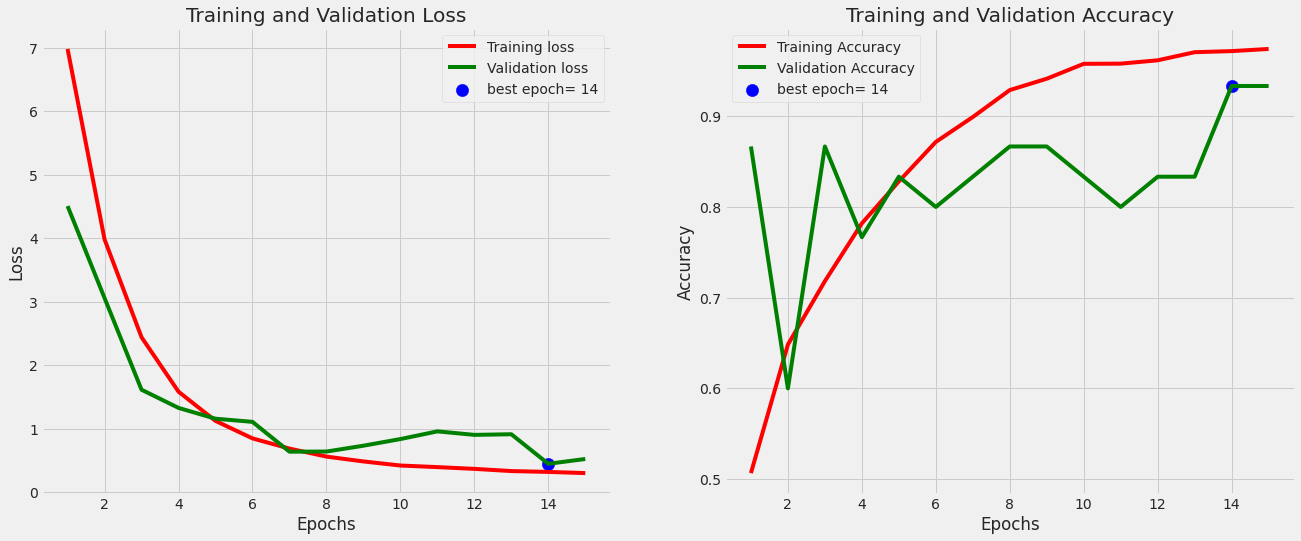

97/97 [==============================] - 1249s 13s/step - loss: 0.8192 - accuracy: 0.8229
accuracy on the test set is 82.29 %

model was saved as ./EfficientNetB3-skin disease-82.29.h5

class csv file was saved as ./class_dict.csv



In [ ]:
tr_plot(history,0)
subject='skin disease'
acc=model.evaluate( test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=False)[1]*100
msg=f'accuracy on the test set is {acc:5.2f} %'
print_in_color(msg, (0,255,0),(55,65,80))
generator=train_gen
scale = 1
model_save_loc, csv_save_loc=saver(working_dir, model, model_name, subject, acc, img_size, scale,  generator)

97/97 [==============================] - 37s 353ms/step


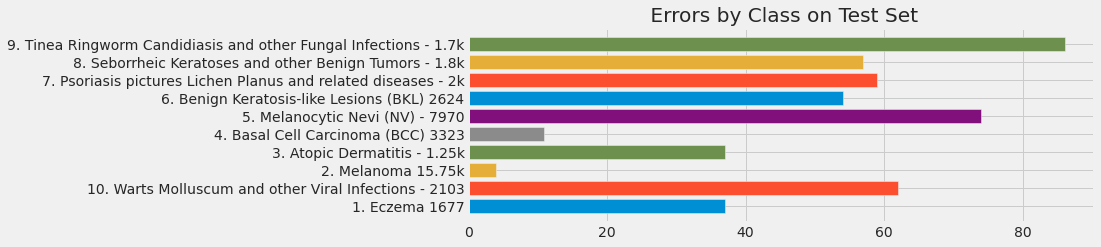

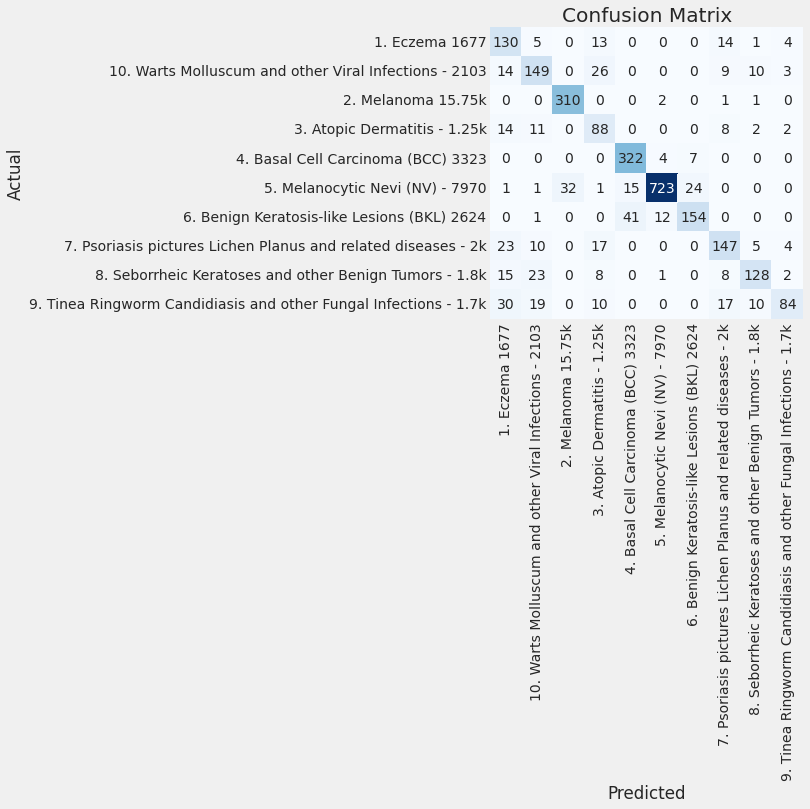

Classification Report:
----------------------
                                                                   precision    recall  f1-score   support

                                                  1. Eczema 1677       0.57      0.78      0.66       167
           10. Warts Molluscum and other Viral Infections - 2103       0.68      0.71      0.69       211
                                              2. Melanoma 15.75k       0.91      0.99      0.95       314
                                    3. Atopic Dermatitis - 1.25k       0.54      0.70      0.61       125
                              4. Basal Cell Carcinoma (BCC) 3323       0.85      0.97      0.91       333
                                 5. Melanocytic Nevi (NV) - 7970       0.97      0.91      0.94       797
                     6. Benign Keratosis-like Lesions (BKL) 2624       0.83      0.74      0.78       208
   7. Psoriasis pictures Lichen Planus and related diseases - 2k       0.72      0.71      0.72       20

In [ ]:
print_code=0
preds=model.predict(test_gen, steps=test_steps, verbose=1) 
print_info( test_gen, preds, print_code, working_dir, subject )  

In [ ]:
store_path=os.path.join(working_dir, 'storage')
if os.path.isdir(store_path):
    shutil.rmtree(store_path)
os.mkdir(store_path)
# input an image of a melanoma
img_path=r'../input/skin-diseases-image-dataset/IMG_CLASSES/2. Melanoma 15.75k/ISIC_6654565.jpg'
img=cv2.imread(img_path,  cv2.IMREAD_REDUCED_COLOR_2)
img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# model was trained on rgb images so convert image to rgb
file_name=os.path.split(img_path)[1]
dst_path=os.path.join(store_path, file_name)
cv2.imwrite(dst_path, img)
# check if the directory was created and image stored
print (os.listdir(store_path))

In [ ]:
csv_path=csv_save_loc # path to class_dict.csv
model_path=model_save_loc # path to the trained model
class_name, probability=predictor(store_path, csv_path,  model_path, crop_image = False) # run the classifier
msg=f' image is of class {class_name} with a probability of {probability * 100: 6.2f} %'
print_in_color(msg, (0,255,255), (65,85,55))

##ResNet 50 code start

In [ ]:

import matplotlib.pyplot as plotter_lib

import numpy as np

import PIL as image_lib

import tensorflow as tflow







In [ ]:
demo_resnet_model = Sequential()

pretrained_model_for_demo= tf.keras.applications.ResNet50(include_top=False,

                   input_shape=(300,300,3),

                   pooling='avg',classes=10,

                   weights='imagenet')

for each_layer in pretrained_model_for_demo.layers:

        each_layer.trainable=False

demo_resnet_model.add(pretrained_model_for_demo)

94765736/94765736 [==============================] - 5s 0us/step


In [ ]:
demo_resnet_model.add(Flatten())

demo_resnet_model.add(Dense(512, activation='relu'))

demo_resnet_model.add(Dense(10, activation='softmax'))

In [ ]:
demo_resnet_model.compile(optimizer=Adam(lr=0.0025),loss='categorical_crossentropy',metrics=['accuracy'])

history_resNet = demo_resnet_model.fit(train_gen, validation_data=valid_gen, epochs=15)

Epoch 1/15
336/336 [==============================] - 9876s 29s/step - loss: 1.3433 - accuracy: 0.4980 - val_loss: 0.8898 - val_accuracy: 0.6593
Epoch 2/15
336/336 [==============================] - 151s 451ms/step - loss: 1.0147 - accuracy: 0.6056 - val_loss: 0.8147 - val_accuracy: 0.6818
Epoch 3/15
336/336 [==============================] - 150s 447ms/step - loss: 0.9271 - accuracy: 0.6402 - val_loss: 0.8490 - val_accuracy: 0.6656
Epoch 4/15
336/336 [==============================] - 150s 446ms/step - loss: 0.8549 - accuracy: 0.6711 - val_loss: 0.8666 - val_accuracy: 0.6715
Epoch 5/15
336/336 [==============================] - 150s 446ms/step - loss: 0.8025 - accuracy: 0.6935 - val_loss: 1.0152 - val_accuracy: 0.6210
Epoch 6/15
336/336 [==============================] - 151s 449ms/step - loss: 0.7332 - accuracy: 0.7184 - val_loss: 0.8331 - val_accuracy: 0.6917
Epoch 7/15
336/336 [==============================] - 151s 449ms/step - loss: 0.6799 - accuracy: 0.7407 - val_loss: 0.8162 - 

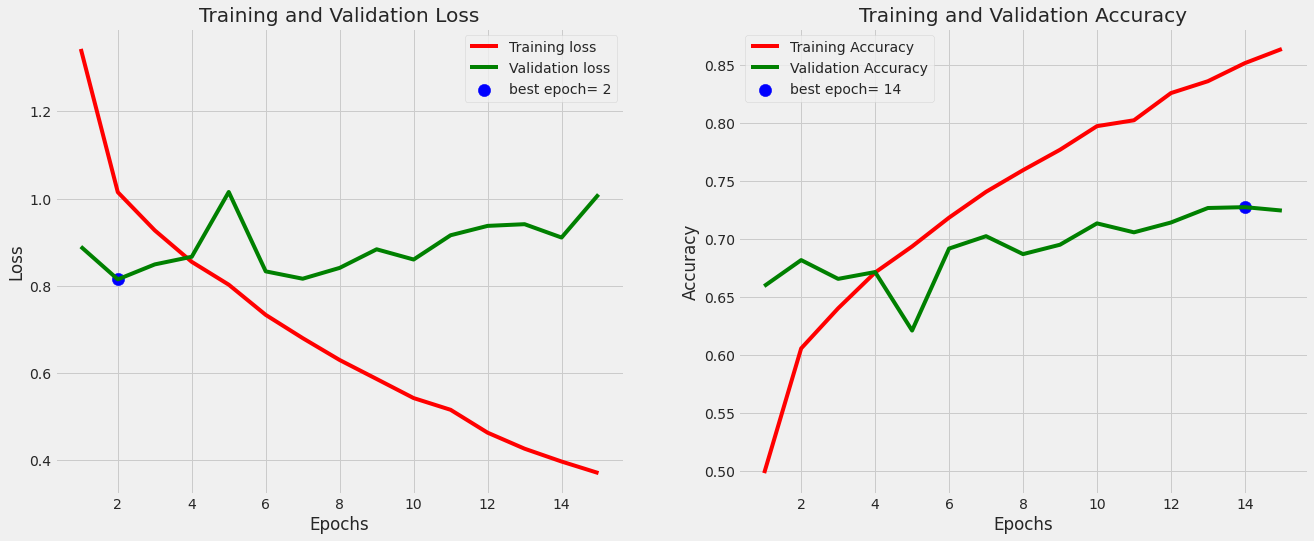

97/97 [==============================] - 36s 374ms/step - loss: 0.9131 - accuracy: 0.7430
accuracy [ResNet50] on the test set is 74.30 %

model was saved as ./resNet50-skin disease-74.30.h5

class csv file was saved as ./class_dict.csv



In [ ]:
tr_plot(history_resNet,0)
subject='skin disease'
acc_resNet=demo_resnet_model.evaluate( test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=False)[1]*100
msg=f'accuracy [ResNet50] on the test set is {acc_resNet:5.2f} %'
print_in_color(msg, (0,255,0),(55,65,80))
generator=train_gen
scale = 1
acc=acc_resNet
model_save_loc, csv_save_loc=saver(working_dir, demo_resnet_model, 'resNet50', subject, acc, img_size, scale,  generator)

97/97 [==============================] - 37s 375ms/step


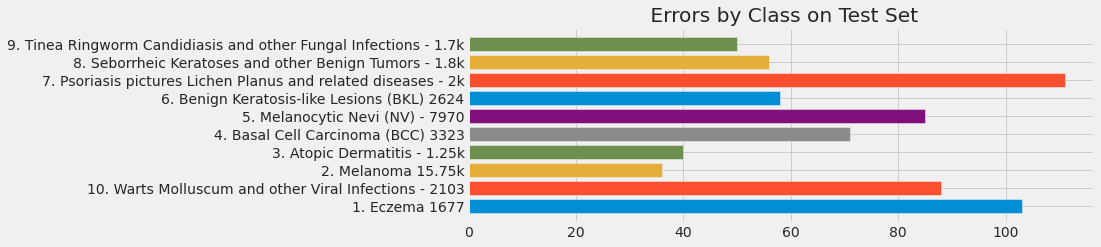

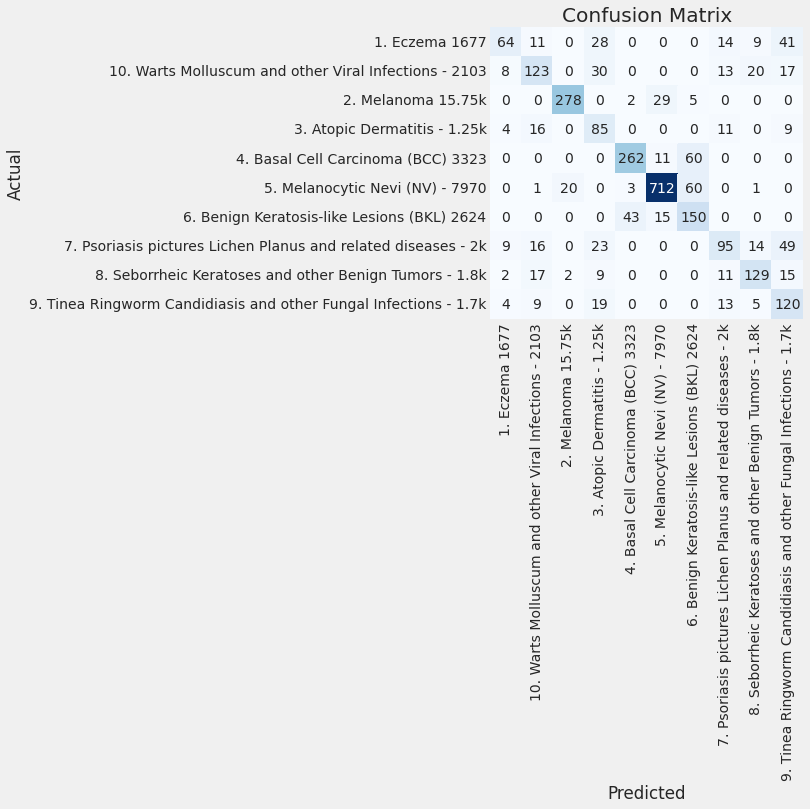

Classification Report:
----------------------
                                                                   precision    recall  f1-score   support

                                                  1. Eczema 1677       0.70      0.38      0.50       167
           10. Warts Molluscum and other Viral Infections - 2103       0.64      0.58      0.61       211
                                              2. Melanoma 15.75k       0.93      0.89      0.91       314
                                    3. Atopic Dermatitis - 1.25k       0.44      0.68      0.53       125
                              4. Basal Cell Carcinoma (BCC) 3323       0.85      0.79      0.81       333
                                 5. Melanocytic Nevi (NV) - 7970       0.93      0.89      0.91       797
                     6. Benign Keratosis-like Lesions (BKL) 2624       0.55      0.72      0.62       208
   7. Psoriasis pictures Lichen Planus and related diseases - 2k       0.61      0.46      0.52       20

In [ ]:
print_code=0
preds=demo_resnet_model.predict(test_gen, steps=test_steps, verbose=1) 
print_info( test_gen, preds, print_code, working_dir, subject )  

##VGG19 code start

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.applications import VGG19
import cv2
import os
import random
import tensorflow as tf

In [ ]:
pre_trained_model = VGG19(input_shape=(300,300,3), include_top=False, weights="imagenet")
#pre_trained_model.trainable = False

for layer in pre_trained_model.layers[:19]:
    layer.trainable = False

vgg19 = Sequential([
    pre_trained_model,
    MaxPool2D((2,2) , strides = 2),
    Flatten(),
    Dense(10 , activation='softmax')])
vgg19.compile(optimizer = "adam" , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
vgg19.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 9, 9, 512)         20024384  
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 512)        0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_1 (Dense)             (None, 10)                81930     
                                                                 
Total params: 20,106,314
Trainable params: 4,801,546
Non-trainable params: 15,304,768
_________________________________________________________________


In [ ]:
from keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 3, verbose=1,factor=0.6, min_lr=0.000001)

In [ ]:
history_vgg19 = vgg19.fit(train_gen, batch_size = 64 , epochs = 15 ,verbose=1, validation_data = valid_gen,callbacks = [learning_rate_reduction])


Epoch 1/15
336/336 [==============================] - 5985s 18s/step - loss: 2.4030 - accuracy: 0.0981 - val_loss: 2.3020 - val_accuracy: 0.0681 - lr: 0.0010
Epoch 2/15
336/336 [==============================] - 181s 540ms/step - loss: 2.3028 - accuracy: 0.0959 - val_loss: 2.3019 - val_accuracy: 0.2936 - lr: 0.0010
Epoch 3/15
336/336 [==============================] - 178s 531ms/step - loss: 2.6346 - accuracy: 0.0929 - val_loss: 2.3011 - val_accuracy: 0.0619 - lr: 0.0010
Epoch 4/15
336/336 [==============================] - 180s 535ms/step - loss: 2.3028 - accuracy: 0.0958 - val_loss: 2.3003 - val_accuracy: 0.2936 - lr: 0.0010
Epoch 5/15
336/336 [==============================] - ETA: 0s - loss: 2.3028 - accuracy: 0.0936
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.
336/336 [==============================] - 180s 534ms/step - loss: 2.3028 - accuracy: 0.0936 - val_loss: 2.3014 - val_accuracy: 0.0626 - lr: 0.0010
Epoch 6/15
336/336 [=========================

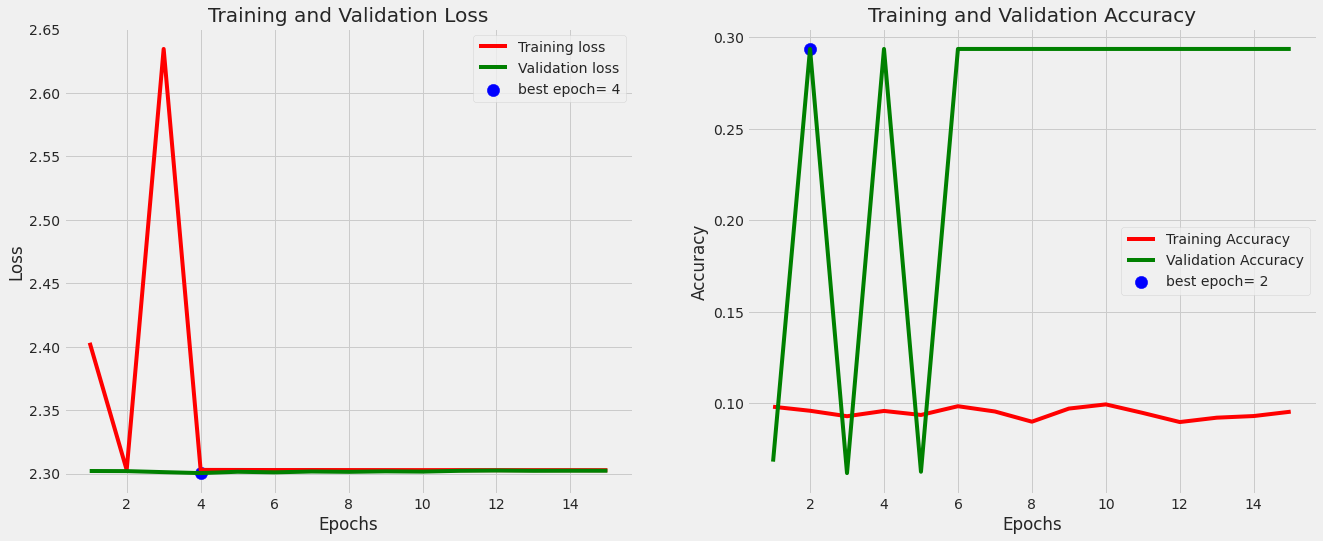

97/97 [==============================] - 1143s 12s/step - loss: 2.3022 - accuracy: 0.2934
accuracy [vgg19] on the test set is 29.34 %

model was saved as ./vgg19-skin disease-29.34.h5

class csv file was saved as ./class_dict.csv



In [ ]:
tr_plot(history_vgg19,0)
subject='skin disease'
acc_vgg19=vgg19.evaluate( test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=False)[1]*100
msg=f'accuracy [vgg19] on the test set is {acc_vgg19:5.2f} %'
print_in_color(msg, (0,255,0),(55,65,80))
generator=train_gen
scale = 1
acc=acc_vgg19
model_save_loc, csv_save_loc=saver(working_dir, vgg19, 'vgg19', subject, acc, img_size, scale,  generator)

97/97 [==============================] - 44s 452ms/step


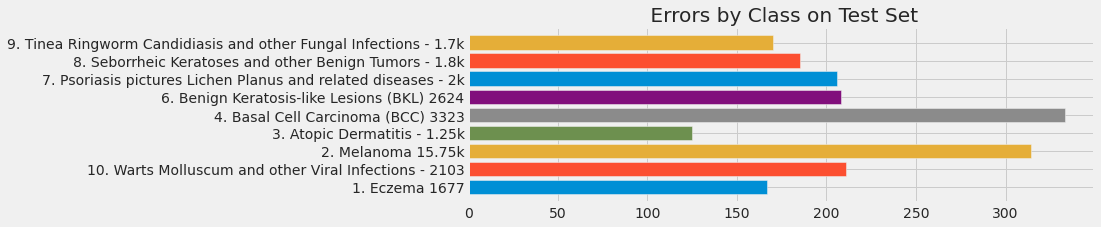

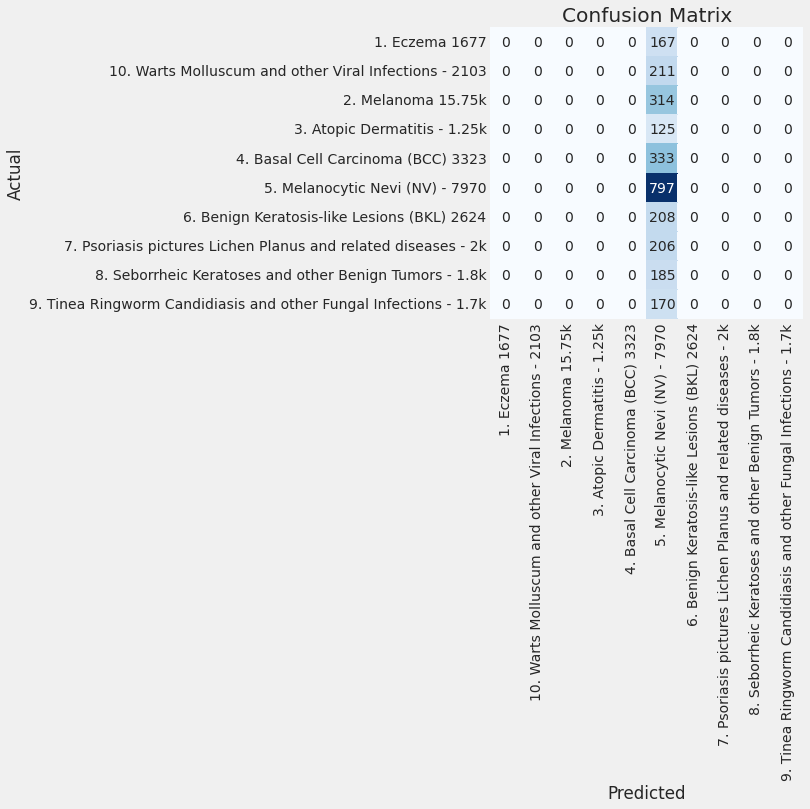

Classification Report:
----------------------
                                                                   precision    recall  f1-score   support

                                                  1. Eczema 1677       0.00      0.00      0.00       167
           10. Warts Molluscum and other Viral Infections - 2103       0.00      0.00      0.00       211
                                              2. Melanoma 15.75k       0.00      0.00      0.00       314
                                    3. Atopic Dermatitis - 1.25k       0.00      0.00      0.00       125
                              4. Basal Cell Carcinoma (BCC) 3323       0.00      0.00      0.00       333
                                 5. Melanocytic Nevi (NV) - 7970       0.29      1.00      0.45       797
                     6. Benign Keratosis-like Lesions (BKL) 2624       0.00      0.00      0.00       208
   7. Psoriasis pictures Lichen Planus and related diseases - 2k       0.00      0.00      0.00       20

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print_code=0
preds=vgg19.predict(test_gen, steps=test_steps, verbose=1) 
print_info( test_gen, preds, print_code, working_dir, subject )  

In [ ]:
#another test on vgg19

history_vgg19 = vgg19.fit(train_gen, epochs = 15 ,verbose=1, validation_data = valid_gen)


Epoch 1/15
336/336 [==============================] - 184s 549ms/step - loss: 2.3026 - accuracy: 0.0906 - val_loss: 2.3023 - val_accuracy: 0.0755
Epoch 2/15
336/336 [==============================] - 182s 542ms/step - loss: 2.3026 - accuracy: 0.0942 - val_loss: 2.3022 - val_accuracy: 0.2936
Epoch 3/15
336/336 [==============================] - 181s 539ms/step - loss: 2.3026 - accuracy: 0.0913 - val_loss: 2.3024 - val_accuracy: 0.2936
Epoch 4/15
336/336 [==============================] - 181s 539ms/step - loss: 2.3026 - accuracy: 0.0940 - val_loss: 2.3024 - val_accuracy: 0.1157
Epoch 5/15
336/336 [==============================] - 180s 535ms/step - loss: 2.3026 - accuracy: 0.0967 - val_loss: 2.3023 - val_accuracy: 0.1157
Epoch 6/15
336/336 [==============================] - 181s 537ms/step - loss: 2.3026 - accuracy: 0.0937 - val_loss: 2.3024 - val_accuracy: 0.1157
Epoch 7/15
336/336 [==============================] - 180s 534ms/step - loss: 2.3026 - accuracy: 0.0930 - val_loss: 2.3024 -

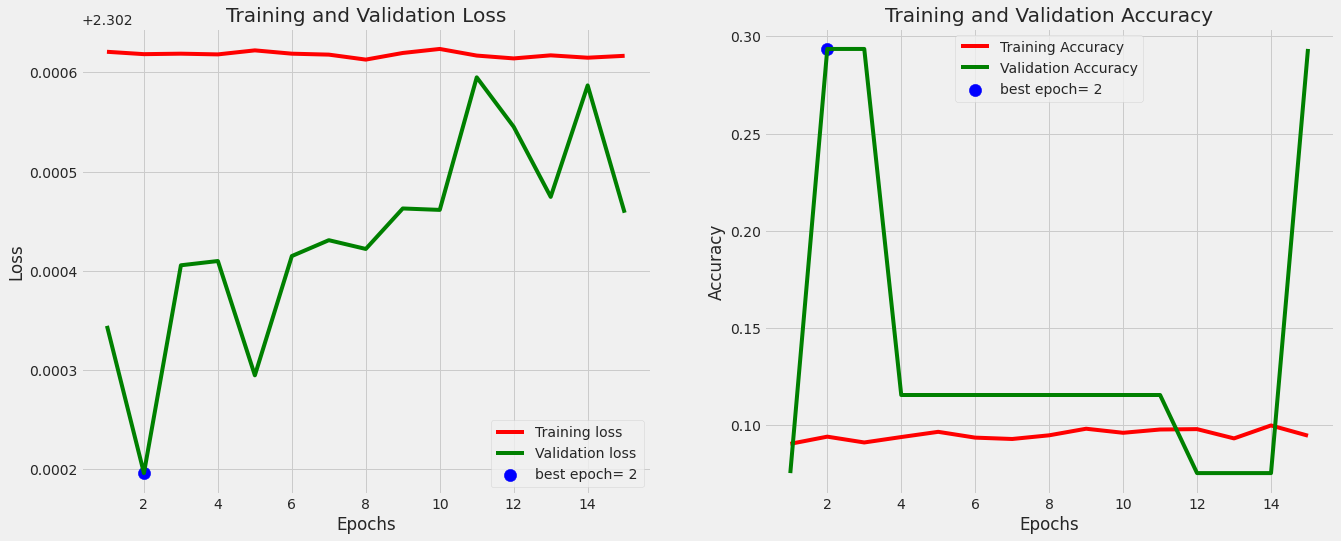

97/97 [==============================] - 41s 425ms/step - loss: 2.3025 - accuracy: 0.2934
accuracy [vgg19] on the test set is 29.34 %

model was saved as ./vgg19-skin disease-29.34.h5

class csv file was saved as ./class_dict.csv



In [ ]:
tr_plot(history_vgg19,0)
subject='skin disease'
acc_vgg19=vgg19.evaluate( test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=False)[1]*100
msg=f'accuracy [vgg19] on the test set is {acc_vgg19:5.2f} %'
print_in_color(msg, (0,255,0),(55,65,80))
generator=train_gen
scale = 1
acc=acc_vgg19
model_save_loc, csv_save_loc=saver(working_dir, vgg19, 'vgg19', subject, acc, img_size, scale,  generator)

97/97 [==============================] - 40s 410ms/step


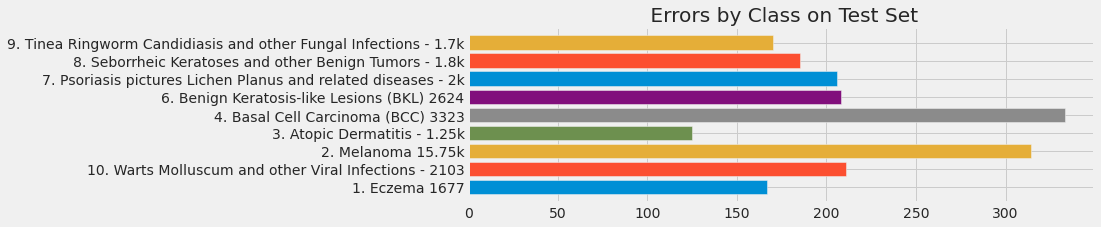

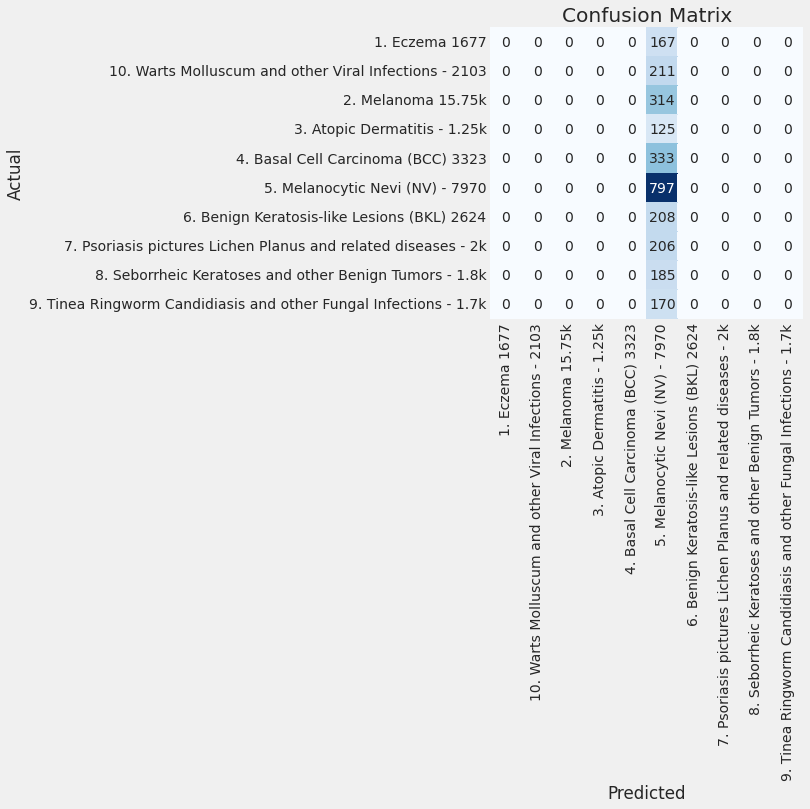

Classification Report:
----------------------
                                                                   precision    recall  f1-score   support

                                                  1. Eczema 1677       0.00      0.00      0.00       167
           10. Warts Molluscum and other Viral Infections - 2103       0.00      0.00      0.00       211
                                              2. Melanoma 15.75k       0.00      0.00      0.00       314
                                    3. Atopic Dermatitis - 1.25k       0.00      0.00      0.00       125
                              4. Basal Cell Carcinoma (BCC) 3323       0.00      0.00      0.00       333
                                 5. Melanocytic Nevi (NV) - 7970       0.29      1.00      0.45       797
                     6. Benign Keratosis-like Lesions (BKL) 2624       0.00      0.00      0.00       208
   7. Psoriasis pictures Lichen Planus and related diseases - 2k       0.00      0.00      0.00       20

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print_code=0
preds=vgg19.predict(test_gen, steps=test_steps, verbose=1) 
print_info( test_gen, preds, print_code, working_dir, subject )  

##Google Net start


In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, GlobalAveragePooling2D, Dense, Dropout
from keras.layers import concatenate

In [ ]:
def Inception_block(input_layer, f1, f2_conv1, f2_conv3, f3_conv1, f3_conv5, f4): 
  # Input: 
  # - f1: number of filters of the 1x1 convolutional layer in the first path
  # - f2_conv1, f2_conv3 are number of filters corresponding to the 1x1 and 3x3 convolutional layers in the second path
  # - f3_conv1, f3_conv5 are the number of filters corresponding to the 1x1 and 5x5  convolutional layer in the third path
  # - f4: number of filters of the 1x1 convolutional layer in the fourth path

  # 1st path:
  path1 = Conv2D(filters=f1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)

  # 2nd path
  path2 = Conv2D(filters = f2_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
  path2 = Conv2D(filters = f2_conv3, kernel_size = (3,3), padding = 'same', activation = 'relu')(path2)

  # 3rd path
  path3 = Conv2D(filters = f3_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
  path3 = Conv2D(filters = f3_conv5, kernel_size = (5,5), padding = 'same', activation = 'relu')(path3)

  # 4th path
  path4 = MaxPooling2D((3,3), strides= (1,1), padding = 'same')(input_layer)
  path4 = Conv2D(filters = f4, kernel_size = (1,1), padding = 'same', activation = 'relu')(path4)

  output_layer = concatenate([path1, path2, path3, path4], axis = -1)

  return output_layer

In [ ]:
def GoogLeNet():
  # input layer 
  input_layer = Input(shape = (300, 300, 3))

  # convolutional layer: filters = 64, kernel_size = (7,7), strides = 2
  X = Conv2D(filters = 64, kernel_size = (7,7), strides = 2, padding = 'valid', activation = 'relu')(input_layer)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)

  # convolutional layer: filters = 64, strides = 1
  X = Conv2D(filters = 64, kernel_size = (1,1), strides = 1, padding = 'same', activation = 'relu')(X)

  # convolutional layer: filters = 192, kernel_size = (3,3)
  X = Conv2D(filters = 192, kernel_size = (3,3), padding = 'same', activation = 'relu')(X)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

  # 1st Inception block
  X = Inception_block(X, f1 = 64, f2_conv1 = 96, f2_conv3 = 128, f3_conv1 = 16, f3_conv5 = 32, f4 = 32)

  # 2nd Inception block
  X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 192, f3_conv1 = 32, f3_conv5 = 96, f4 = 64)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

  # 3rd Inception block
  X = Inception_block(X, f1 = 192, f2_conv1 = 96, f2_conv3 = 208, f3_conv1 = 16, f3_conv5 = 48, f4 = 64)

  # Extra network 1:
  X1 = AveragePooling2D(pool_size = (5,5), strides = 3)(X)
  X1 = Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', activation = 'relu')(X1)
  X1 = Flatten()(X1)
  X1 = Dense(1024, activation = 'relu')(X1)
  X1 = Dropout(0.7)(X1)
  X1 = Dense(10, activation = 'softmax')(X1)

  
  # 4th Inception block
  X = Inception_block(X, f1 = 160, f2_conv1 = 112, f2_conv3 = 224, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

  # 5th Inception block
  X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 256, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

  # 6th Inception block
  X = Inception_block(X, f1 = 112, f2_conv1 = 144, f2_conv3 = 288, f3_conv1 = 32, f3_conv5 = 64, f4 = 64)

  # Extra network 2:
  X2 = AveragePooling2D(pool_size = (5,5), strides = 3)(X)
  X2 = Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', activation = 'relu')(X2)
  X2 = Flatten()(X2)
  X2 = Dense(1024, activation = 'relu')(X2)
  X2 = Dropout(0.7)(X2)
  X2 = Dense(10, activation = 'softmax')(X2)
  
  
  # 7th Inception block
  X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, 
                      f3_conv5 = 128, f4 = 128)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)

  # 8th Inception block
  X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, f3_conv5 = 128, f4 = 128)

  # 9th Inception block
  X = Inception_block(X, f1 = 384, f2_conv1 = 192, f2_conv3 = 384, f3_conv1 = 48, f3_conv5 = 128, f4 = 128)

  # Global Average pooling layer 
  X = GlobalAveragePooling2D(name = 'GAPL')(X)

  # Dropoutlayer 
  X = Dropout(0.4)(X)

  # output layer 
  X = Dense(10, activation = 'softmax')(X)
  
  # model
  model = Model(input_layer, [X, X1, X2], name = 'GoogLeNet')

  return model

In [ ]:
googleNet = GoogLeNet()
googleNet.compile(optimizer = "adam" , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
googleNet.summary()


Model: "GoogLeNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 147, 147, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 73, 73, 64)   0           ['conv2d[0][0]']                 
                                                                                          

In [ ]:
history_googleNet = googleNet.fit(train_gen, epochs = 15 ,verbose=1, validation_data = valid_gen)

Epoch 1/15
336/336 [==============================] - 4268s 13s/step - loss: 7.0306 - dense_4_loss: 2.3168 - dense_1_loss: 2.3807 - dense_3_loss: 2.3331 - dense_4_accuracy: 0.0994 - dense_1_accuracy: 0.0989 - dense_3_accuracy: 0.0990 - val_loss: 6.9258 - val_dense_4_loss: 2.3141 - val_dense_1_loss: 2.3101 - val_dense_3_loss: 2.3016 - val_dense_4_accuracy: 0.0755 - val_dense_1_accuracy: 0.0755 - val_dense_3_accuracy: 0.0807
Epoch 2/15
336/336 [==============================] - 158s 471ms/step - loss: 6.9395 - dense_4_loss: 2.3039 - dense_1_loss: 2.3289 - dense_3_loss: 2.3067 - dense_4_accuracy: 0.1014 - dense_1_accuracy: 0.0999 - dense_3_accuracy: 0.0961 - val_loss: 6.9288 - val_dense_4_loss: 2.3071 - val_dense_1_loss: 2.3080 - val_dense_3_loss: 2.3137 - val_dense_4_accuracy: 0.0464 - val_dense_1_accuracy: 0.0652 - val_dense_3_accuracy: 0.0464
Epoch 3/15
336/336 [==============================] - 156s 464ms/step - loss: 6.9312 - dense_4_loss: 2.3196 - dense_1_loss: 2.3069 - dense_3_loss

In [ ]:

acc_googleNet=googleNet.evaluate( test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=False)[1]*100
msg=f'accuracy [vgg19] on the test set is {acc_googleNet:5.2f} %'
print_in_color(msg, (0,255,0),(55,65,80))
generator=train_gen
scale = 1


97/97 [==============================] - 894s 9s/step - loss: 6.9113 - dense_4_loss: 2.3026 - dense_1_loss: 2.3043 - dense_3_loss: 2.3044 - dense_4_accuracy: 0.0777 - dense_1_accuracy: 0.0773 - dense_3_accuracy: 0.0615
accuracy [vgg19] on the test set is 230.26 %



In [ ]:
print_code=0
preds=vgg19.predict(test_gen, steps=test_steps, verbose=1) 
print_info( test_gen, preds, print_code, working_dir, subject)  